In [158]:
import itertools

import mdshare
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, trange

In [159]:
device = torch.device('mps')

In [160]:
data_file_path: str = mdshare.fetch('alanine-dipeptide-3x250ns-heavy-atom-positions.npz', working_directory='data') # type: ignore

with np.load(data_file_path) as npz:
  data = [npz[file_name].astype(np.float32) for file_name in npz]

input_var_count = data[0].shape[1]

In [161]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, input_size: int, output_size: int):
    super().__init__()

    self.sequence = nn.Sequential(
      nn.Linear(input_size, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, output_size)
    )

  def forward(self, x):
    return self.sequence(x)

In [162]:
data[0].shape

(250000, 30)

In [163]:
trajectories = torch.tensor(np.array(data)).to(device)

loader = DataLoader(TensorDataset(
  torch.full((trajectories[0].size(0) - 1,), 0),
  torch.arange(trajectories[0].size(0) - 1)
), batch_size=1024, shuffle=True)

# next(iter(loader))
# trajectories[0].size()

In [164]:
trajectories.size()

torch.Size([3, 250000, 30])

In [166]:
def distance(a: torch.Tensor, b: torch.Tensor):
  return (0.5 * (a - b) ** 2).sum(dim=-1)

def distance_neg(a: torch.Tensor, b: torch.Tensor, *, eps: float):
  return torch.relu(eps - distance(a, b))

latent_var_count = 10
background_step_count = 12
epsilon = 3.0

Z = FeedForwardNetwork(input_var_count, latent_var_count).to(device)
A = FeedForwardNetwork(latent_var_count, latent_var_count).to(device)

def T(x: torch.Tensor):
  return x + A(x)

optimizer = torch.optim.SGD(itertools.chain(A.parameters(), Z.parameters()), lr=1e-5)
epoch_count = 10
losses = torch.zeros(epoch_count)

for epoch in range(epoch_count):
  epoch_loss = 0

  for traj_indices, step_indices in tqdm(loader):
    current_step = trajectories[traj_indices, step_indices, :]
    next_step = trajectories[traj_indices, step_indices + 1, :]

    rand_indices = torch.randint(0, trajectories.size(1) - 1, (background_step_count, len(traj_indices)), device=device)
    rand_step = trajectories[traj_indices, rand_indices, :]

    tz = T(Z(current_step))
    loss = (distance(Z(next_step), tz) + distance_neg(Z(rand_step), tz, eps=epsilon).sum(dim=0)).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  losses[epoch] = epoch_loss


100%|██████████| 245/245 [00:03<00:00, 61.94it/s]


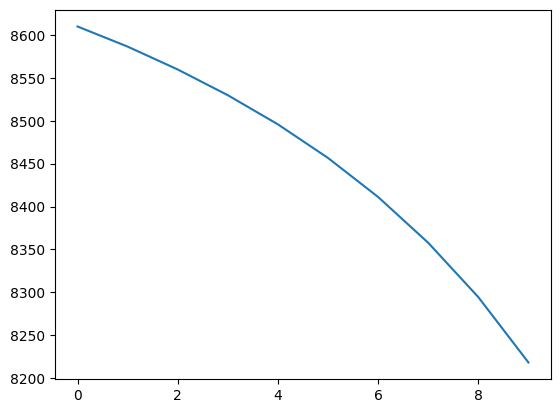

In [167]:
fig, ax = plt.subplots()

ax.plot(losses);

In [168]:
losses

tensor([8609.9639, 8586.4941, 8559.8086, 8529.8203, 8495.8057, 8456.6289,
        8411.1172, 8357.7041, 8294.3447, 8218.1309])